In [1]:
import math
import torch
import itertools
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import torch.profiler as profiler
from tensorboardX import SummaryWriter
import datetime
import warnings
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from typing import Optional, Tuple
warnings.filterwarnings('ignore')

# Retrieve data

In [2]:
parquet_file = '../data/D16.04.27G04.26.18.25.50.parquet'
df_by_store = pd.read_parquet(parquet_file)
df_by_store

,date,resource_id,earnings
0,2016-04-27,1,197311.539083
1,2016-04-27,2,146640.343591
2,2016-04-27,3,83049.201349
3,2016-04-27,4,50834.116619
4,2016-04-27,5,41600.032533
...,...,...,...
0,2021-04-25,1,79689.614124
1,2021-04-25,2,171168.014765
2,2021-04-25,3,107963.660107
3,2021-04-25,4,15664.154214


In [3]:
writer = SummaryWriter('logs')

Text(0, 0.5, 'Earnings')

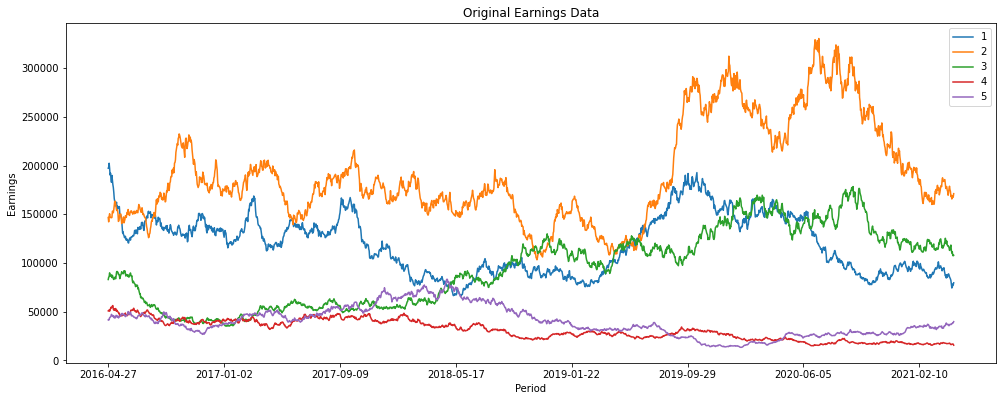

In [4]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_by_store.groupby(['resource_id']):
    ax = grp.plot(ax=ax, kind='line', x='date', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Original Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')

## Start with Aggregate Data

In [5]:
# get cumulative earnings into sequence
df_stores_total_daily = df_by_store.groupby(by=['date']).sum()['earnings'].reset_index()
df_stores_total_daily.head()

,date,earnings
0,2016-04-27,519435.233176
1,2016-04-28,519452.879999
2,2016-04-29,529583.377875
3,2016-04-30,531999.483430
4,2016-05-01,520668.272661


In [6]:
df_stores_total_daily['Year'] = pd.to_datetime(df_stores_total_daily['date']).dt.year
df_stores_total_daily['Month'] = pd.to_datetime(df_stores_total_daily['date']).dt.month
df_stores_total_daily['WeekOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day.apply(lambda day: math.ceil(int(day)/7))
df_stores_total_daily['WeekOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.week
df_stores_total_daily['DayOfMonth'] = pd.to_datetime(df_stores_total_daily['date']).dt.day
df_stores_total_daily['DayOfYear'] = pd.to_datetime(df_stores_total_daily['date']).dt.dayofyear

df_stores_total_daily.head()

,date,earnings,Year,Month,WeekOfMonth,WeekOfYear,DayOfMonth,DayOfYear
0,2016-04-27,519435.233176,2016,4,4,17,27,118
1,2016-04-28,519452.879999,2016,4,4,17,28,119
2,2016-04-29,529583.377875,2016,4,5,17,29,120
3,2016-04-30,531999.483430,2016,4,5,17,30,121
4,2016-05-01,520668.272661,2016,5,1,17,1,122


In [7]:
# get cumulative earnings into sequence
df_stores_total_monthly = df_stores_total_daily.groupby(by=['Month','Year']).sum()['earnings'].reset_index()
df_stores_total_monthly.head()

,Month,Year,earnings
0,1,2017,1.292345e+07
1,1,2018,1.356725e+07
2,1,2019,1.287119e+07
3,1,2020,1.910196e+07
4,1,2021,1.430104e+07


Text(0, 0.5, 'Earnings')

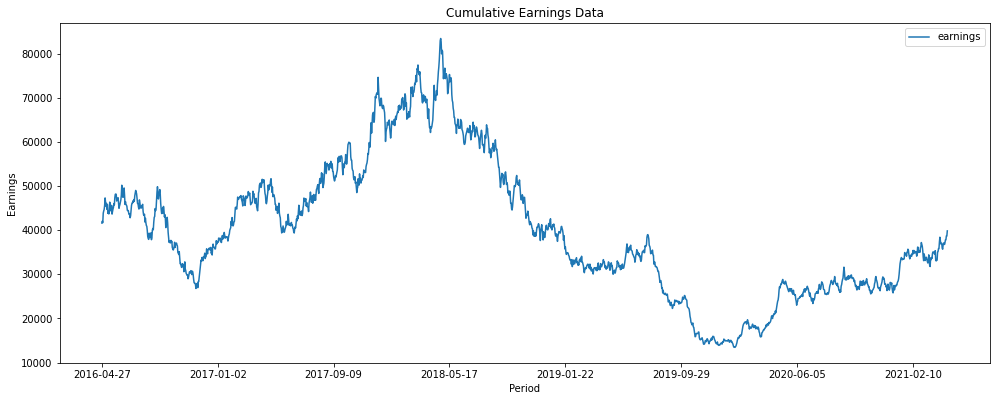

In [8]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = grp.plot(ax=ax, kind='line', x='date', y='earnings')
leg = ax.legend()
plt.title(f'Cumulative Earnings Data')
plt.xlabel('Period')
plt.ylabel('Earnings')


Text(0, 0.5, 'Earnings')

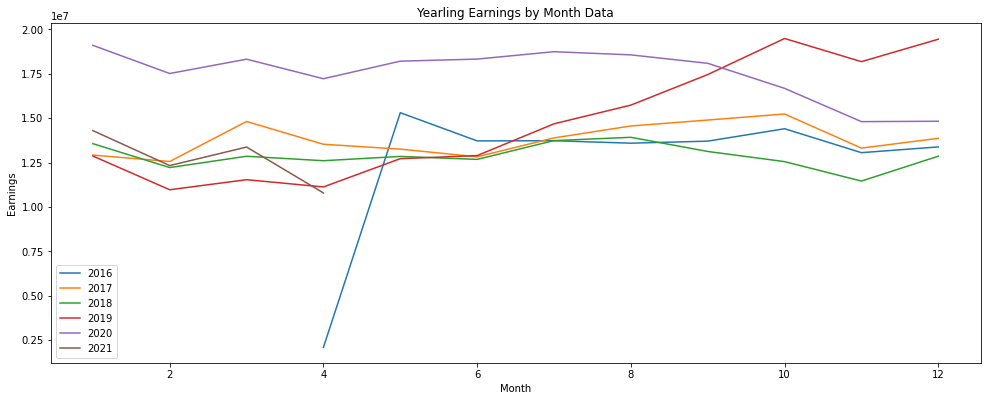

In [9]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
for key, grp in df_stores_total_monthly.groupby(['Year']):
    ax = grp.plot(ax=ax, kind='line', x='Month', y='earnings', label=key)
leg = ax.legend()
plt.title(f'Yearling Earnings by Month Data')
plt.xlabel('Month')
plt.ylabel('Earnings')

# Split Data

In [10]:
#split data
data_all = df_stores_total_daily.earnings
sz = len(data_all)
test_sz = math.floor(.2 * sz)
sz, test_sz

(1825, 365)

In [11]:
train_data = data_all[:-test_sz]
test_data = data_all[-test_sz:]
len(train_data)+len(test_data), len(test_data)

(1825, 365)

In [12]:
msmin, msmax = train_data.min(), train_data.max()
print(f'Min: {msmin}, Max: {msmax}')
train_data_scaled = (train_data - msmin) / (msmax - msmin)

Min: 356723.33566985116, Max: 653900.1718112999


Text(0, 0.5, 'Earnings')

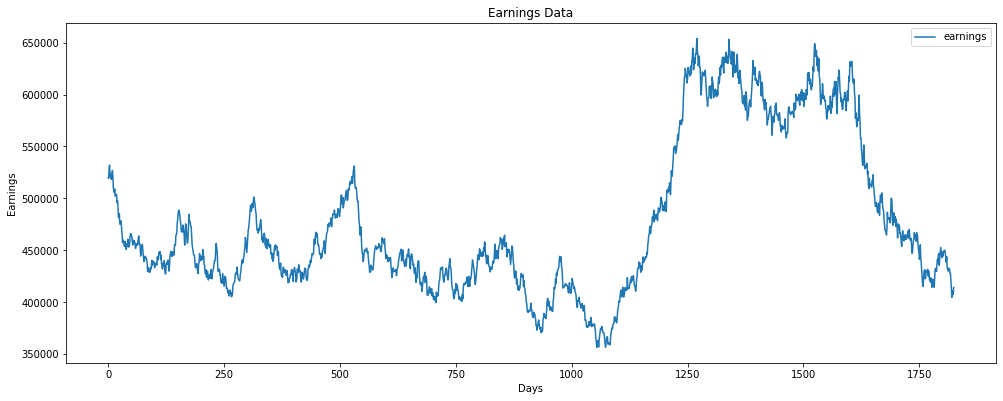

In [13]:
fig, ax = plt.subplots(figsize=(1600/96., 600/96.))
ax = data_all.plot(ax=ax, kind='line', x='days', y='earnings')
leg = ax.legend()
plt.title(f'Earnings Data')
plt.xlabel('Days')
plt.ylabel('Earnings')



# Create Dataset with Lookback

In [14]:
# lookback window
window = 100

In [15]:
class SeqDataset(Dataset):
    def __init__(self, sequence: torch.Tensor, window: int) -> None:
        self.sz = len(sequence) - window
        self.win = window
        self.seq = sequence

    def __len__(self) -> int:
        return self.sz

    def __getitem__(self, i: int) -> Tuple[torch.Tensor, torch.Tensor]:
        e = i + self.win
        return self.seq[i:e], self.seq[e:e+1]

    def scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence - min) / (max - min)

    def inverse_scale(sequence: torch.Tensor, min: float, max: float) -> torch.Tensor:
        return (sequence*(max - min)) + min



In [16]:
# min/max for scaling
cmin, cmax = data_all.min(), data_all.max()
print(f'{cmin} to {cmax}')
metadata = { 
    "min": float(cmin), 
    "max": float(cmax), 
    "window": window 
}
# scale
data_all = SeqDataset.scale(data_all, cmin, cmax)
# data split
test_sz = math.floor(0.20 * len(data_all))
train_data = torch.FloatTensor(data_all[:-test_sz])
val_data = torch.FloatTensor(data_all.to_numpy()[-test_sz:])
# create sequence datasets
train_dataset = SeqDataset(train_data, window)
val_dataset = SeqDataset(val_data, window)

356723.33566985116 to 653900.1718112999


In [26]:
trainloader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)

# Model

In [27]:
# Model params
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 10

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [28]:
import torch
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        out, (hn) = self.gru(x.view(-1, x.size(1), 1), (h0.detach()))
        out = self.fc(out[:, -1, :])
        return out

In [29]:
model = GRU(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)

In [31]:
criterion = torch.nn.MSELoss(reduction='mean').to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
        ],
    schedule=torch.profiler.schedule(
        wait=2,
        warmup=3,
        active=6),
    on_trace_ready=torch.profiler.tensorboard_trace_handler('./logs',"test"),
    record_shapes=True
) as p:


    for step, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device=device), data[1].to(device=device)
        y_train_pred = model(inputs)
        loss = criterion(y_train_pred, labels)
        print("Epoch ", t, "MSE: ", loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
        writer.add_scalar('GRU Training Loss', loss.item(), t)
        p.step()

Epoch  0 MSE:  0.23203419148921967
Epoch  0 MSE:  0.041376978158950806


AssertionError: 

In [ ]:

# Use profiler to analyze execution time

input = test_data[0]
with profiler.profile(record_shapes=True) as prof:
    with profiler.record_function("model_inference"):
        model(y_train.to(device))
prof.export_chrome_trace("logs/trace.json")

IndexError: dimension specified as 0 but tensor has no dimensions

In [ ]:
print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         6.19%     442.000us        99.50%       7.104ms       7.104ms       0.000us         0.00%     190.000us     190.000us             1  
                                              aten::gru         0.90%      64.000us        49.51%       3.535ms       3.535ms       0.000us         0.00%     116.000us     116.000us             1  
         

In [ ]:
writer.close()